# Figure of station profile model evaluation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pickle
from datetime import date
from datetime import datetime
import xarray as xr
import glob
import gsw

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import seaborn as sns

###### Parameters:

In [9]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# results to plot:
folder_ref = f'/data/brogalla/run_storage/Mn-reference-202110/ANHA12_ref-2004_20211012/'
folder_bio = f'/data/brogalla/run_storage/Mn-bio-202110/ANHA12_bio-2004_20211022/'

# colours:
c_continent    = '#ce9169'
c_glacier      = '#36ab92'
c_other        = '#a6a6a6'
land_color     = "#8b7765"
profile_colors = ['#e54141', '#33c7ff']

##### Load files:

In [5]:
def calculate_average(folder):
    # Calculate average over data files during cruise period:
    files_ref      = np.sort(glob.glob(f'{folder}ANHA12_EXH006_5d_20040101_20041231*'))
    start_date_ref = datetime.strptime('2004-08-09', '%Y-%m-%d')
    end_date_ref   = datetime.strptime('2004-09-15', '%Y-%m-%d')

    file_list_ref = []
    for file in files_ref:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_ref) & \
                (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_ref):
            file_list_ref.append(file)
    dmn_ref = np.zeros((50,700,640))
    days = 0
    for file in file_list_ref:
        ds = xr.open_dataset(f"{file}")
        dmn_ref = dmn_ref + ds['dissolmn'].values[0,:,:,:]

    mn_dis_ref = dmn_ref / len(file_list_ref)
    
    return mn_dis_ref

In [6]:
mn_ref = calculate_average(folder_ref)
mn_bio = calculate_average(folder_bio)

Model results

In [10]:
model_ref    = nc.Dataset(f'{folder_ref}ANHA12_EXH006_2004_monthly.nc')
lon_model    = np.array(model_ref.variables['nav_lon'])
lat_model    = np.array(model_ref.variables['nav_lat'])
depths_model = np.array(model_ref.variables['deptht'])

In [11]:
sal = nc.Dataset(f'/data/brogalla/ANHA12/salinity_ave/ANHA12-EXH006_gridT_y2015m08.nc')
tem = nc.Dataset(f'/data/brogalla/ANHA12/salinity_ave/ANHA12-EXH006_gridT_y2015m08_temper.nc')
vosal = np.array(sal.variables['vosaline'])[0,:,imin:imax,jmin:jmax]
temp  = np.array(tem.variables['votemper'])[0,:,imin:imax,jmin:jmax]
density_model = gsw.density.sigma0(vosal, temp)

Meshes

In [12]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask    =  np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
mlons    = np.array(mesh.variables['nav_lon'])
mlats    = np.array(mesh.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

Observations

In [13]:
# Concentration of dMn in the Beaufort Sea in 2009.
### Thesis doesn't have a list of lats and lons of station locations --- Jeffrey Charter's thesis does (2012)
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = IPY['Station name'].astype('string').values
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn_nmolkg = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values

# Unique entries (maintaining order)
IPY_lons  = np.array(list(dict.fromkeys(IPY_lons_full)))
IPY_lats  = np.array(list(dict.fromkeys(IPY_lats_full)))
IPY_names = np.array(list(dict.fromkeys(IPY_names_full)))

# Convert nmol / kg to nmol / L
IPY_density             = IPY['Density'].astype('float').values - 1000 # kg / L
IPY_depths_cruise_sheet = IPY['Depth [m] cruise sheet'].astype('float').values
IPY_dMn_nmolL = IPY_dMn_nmolkg * (IPY_density+1000)/1000

In [14]:
# Concentration of dMn in 2015
# Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Fe&Mn_Integrated_Data_UBC-UVic_4-17-19_editedBR.csv')
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/DMn_nmolL-1_BR-edited.csv')
Manuel_station_names = Manuel['Station'].astype('string')
Manuel_depths        = Manuel['Depth'].astype('float')
Manuel_dMn_nmolkg    = Manuel['nmol kg-1'].astype('float').values
Manuel_dMn_nmolL     = Manuel['nmol L-1'].astype('float').values
Manuel_salinity      = Manuel['Salinity'].astype('float').values

In [15]:
GEOTRACES_CTD = pd.read_csv('/ocean/brogalla/GEOTRACES/data/combined.csv')
CTD_stations  = GEOTRACES_CTD['Station'].astype('string')
CTD_temp      = GEOTRACES_CTD['Temperature [ITS-90, deg C]'].astype('float')
CTD_sal       = GEOTRACES_CTD['Salinity, Practical [PSU]'].astype('float')
CTD_depth     = GEOTRACES_CTD['Depth [salt water, m], lat = 49.00'].astype('float')

In [16]:
GEOTRACES = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES['Station names'].dropna().astype('str')
lons      = GEOTRACES['station lon'].astype('float').dropna().values
lats      = GEOTRACES['Station lat'].astype('float').dropna().values

In [17]:
CTD_temp_match = np.empty(Manuel_salinity.shape)
CTD_sal_match  = np.empty(Manuel_salinity.shape)
i = 0

for stn in stn_names:
    # Pair salinities from Manuel with temperatures from the CTD:
    temp_data  = CTD_temp[CTD_stations==stn].values
    sal_data   = CTD_sal[CTD_stations==stn].values
    depth_data = CTD_depth[CTD_stations==stn].values

    for depth in Manuel_depths[Manuel_station_names==stn]:
        try:
            ind_match = np.argmin(np.abs(depth_data-depth))
        
            CTD_temp_match[i] = temp_data[ind_match]   
            CTD_sal_match[i]  = sal_data[ind_match]    
        except:
            CTD_temp_match[i] = np.nan
            CTD_sal_match[i]  = np.nan
            
        i+=1
        
# calculate density Manuel:
GEOTRACES_density = gsw.density.sigma0(CTD_sal_match, CTD_temp_match)

In [18]:
# Connect these points with straight line segments:
transect_lons = [lons[stn_names=='CB4'], lons[stn_names=='CB3'],lons[stn_names=='CB2'], lons[stn_names=='CB1'], \
                 lons[stn_names=='CAA8'], lons[stn_names=='CAA6'], lons[stn_names=='CAA7'], lons[stn_names=='CAA4'],\
                 lons[stn_names=='CAA5'], lons[stn_names=='CAA1'], lons[stn_names=='CAA2'], lons[stn_names=='CAA3']]
transect_lats = [lats[stn_names=='CB4'], lats[stn_names=='CB3'],lats[stn_names=='CB2'], lats[stn_names=='CB1'], \
                 lats[stn_names=='CAA8'], lats[stn_names=='CAA6'], lats[stn_names=='CAA7'], lats[stn_names=='CAA4'],\
                 lats[stn_names=='CAA5'], lats[stn_names=='CAA1'], lats[stn_names=='CAA2'], lats[stn_names=='CAA3']]
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3']

In [ ]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

##### Define functions

In [ ]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = int(i)
        transect_j = int(j)
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, int(i))
            transect_j = np.append(transect_j, int(j))
    
    return transect_i, transect_j

In [21]:
def station_profile(ax, name, manuel=False, patch=False, full=True):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([-0.1, 0.1])
    ax.plot([0,0],[4000,0], '-k')
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([-0.1,0,0.1])
       
    # observations: -------------------------------------------------------------------------------------------
    if manuel:
        dMn_obs   = Manuel_dMn_nmolL[np.array(Manuel_station_names==name).astype('bool')]
        depth_obs = Manuel_depths[np.array(Manuel_station_names==name).astype('bool')].values
    else:
        dMn_obs   = IPY_dMn_nmolL[np.array(IPY_names_full==name).astype('bool')]
        depth_obs = IPY_depths_cruise_sheet[np.array(IPY_names_full==name).astype('bool')]

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    if manuel:
        lon_station = lons[stn_names==name]
        lat_station = lats[stn_names==name]

        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);

        mn_diff = mn_bio[:, model_stni, model_stnj]*10**9 - mn_ref[:, model_stni, model_stnj]*10**9 
    else:
        lon_station = IPY_lons[IPY_names==name]
        lat_station = IPY_lats[IPY_names==name]

        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);

        mn_diff = mn_bio[:, model_stni, model_stnj]*10**9 - mn_ref[:, model_stni, model_stnj]*10**9

    mn_ref_masked  = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), mn_diff) # -1 because of subset of full model domain
    
    ################### full water column #############################
    if full:
        # Run with sediment in sea ice:
        ax.plot(mn_ref_masked, depths_model, '-', \
                zorder=1, linewidth=2.0, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)
        
        ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
        ax.text(0.0, plot_depth_lowerrange*0.99, name, fontsize=6)

        if patch:
            # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -0.2;     y0_top     = -(plot_depth_lowerrange*0.3);
            width_top  = 0.3;      height_top = (plot_depth_lowerrange*0.3);
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                              alpha=0.9, zorder=1)
            ax.add_patch(box_top)

            #left side patch:
            x0_side     = -0.2
            y0_side     = 0#-(plot_depth_lowerrange*0.04)
            width_side  = 0.3
            height_side = plot_depth_lowerrange*1.24
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
       
    ################### zoom in on the surface #############################
    else:
        # Run with sediment in sea ice:
        ax.plot(mn_ref_masked, depths_model, '-', \
                zorder=1, linewidth=2.0, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)

        ax.set_ylim([150, 0])
        ax.text(0.0, 96, name, fontsize=6)

        if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
            #top patch:
            x0_top     = -0.2;     y0_top     = -30;
            width_top  = 0.3; height_top = 30;
            box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                               alpha=0.9, zorder=1)
            ax.add_patch(box_top)
            
            #left side patch:
            x0_side     = -0.2;     y0_side     = 0;
            width_side  = 0.3;     height_side = 105;
            box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                                facecolor='w', clip_on=False, alpha=0.9, zorder=1)
            ax.add_patch(box_side)
    return

In [22]:
def station_profile_density(ax, name, manuel=False, patch=False):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    ax.set_xlim([-2, 15])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([0,5,10,10,15])
       
    # observations: -------------------------------------------------------------------------------------------
    if manuel:
        dMn_obs   = Manuel_dMn_nmolL[np.array(Manuel_station_names==name).astype('bool')]
        sigma_obs = GEOTRACES_density[np.array(Manuel_station_names==name).astype('bool')]
        depth_obs = Manuel_depths[np.array(Manuel_station_names==name).astype('bool')].values
    else:
        dMn_obs   = IPY_dMn_nmolL[np.array(IPY_names_full==name).astype('bool')]
        sigma_obs = IPY_density[np.array(IPY_names_full==name).astype('bool')]
        depth_obs = IPY_depths_cruise_sheet[np.array(IPY_names_full==name).astype('bool')]

    ax.plot(dMn_obs, sigma_obs, '.-', 
            zorder=4, markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0], markersize=7, linewidth=1.8)

    plot_depth_lowerrange = depth_obs[-1] # deepest observation    
    plot_depth_upperrange = depth_obs[0]  # shallowest observation
    
    # model: --------------------------------------------------------------------------------------------------
    if manuel:
        lon_station = lons[stn_names==name]
        lat_station = lats[stn_names==name]

        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);

        mn_ref = mn_ref_2015[:, model_stni, model_stnj]*10**9
        density = density_model[:, model_stni-1, model_stnj-1]
    else:
        lon_station = IPY_lons[IPY_names==name]
        lat_station = IPY_lats[IPY_names==name]

        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);

        mn_ref = mn_ref_2009[:, model_stni, model_stnj]*10**9
        density = density_model[:, model_stni-1, model_stnj-1]

    mn_ref_masked = np.ma.masked_where((tmask[:,model_stni-1, model_stnj-1] < 0.1), mn_ref)
    
    ################### full water column #############################
    # Run with sediment in sea ice:
#     ax.plot(mn_ref_masked, density, '.', zorder=1, linewidth=1.8, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)
    ax.plot(mn_ref_masked[depths_model > plot_depth_upperrange], \
            density[depths_model > plot_depth_upperrange], '.-', \
            zorder=1, linewidth=1.8, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)
#     ax.set_ylim([30, 20])
    ax.text(0.5, 27, name, fontsize=6)

    if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
        #top patch:
        x0_top     = -11
        y0_top     = -(30*0.3)
    return

In [23]:
def full_figure(ln_full=True, savefig=False, title=''):
    
    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))
    #--------------------------------------------------------------------------------------------------------------------------
    ### Left plot ###

    # profile plots:
    ax1 = plt.axes([0.155, 0.15, 0.05, 0.17]) #L1
    ax2 = plt.axes([0.155, 0.39, 0.05, 0.17]) #L1.1 
    ax3 = plt.axes([0.155, 0.66, 0.05, 0.17]) #L1.5 
    ax4 = plt.axes([0.3, 0.66, 0.05, 0.17])  #L2
    ax5 = plt.axes([0.3, 0.39, 0.05, 0.17]) #L3
    ax6 = plt.axes([0.3, 0.15, 0.05, 0.17])  #S4
    axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

    fig1 = station_profile(ax1, 'L1',   full=ln_full)
    fig2 = station_profile(ax2, 'L1.1', full=ln_full)
    fig3 = station_profile(ax3, 'L1.5', full=ln_full)
    fig4 = station_profile(ax4, 'L2',   full=ln_full)
    fig5 = station_profile(ax5, 'L3',   full=ln_full)
    fig6 = station_profile(ax6, 'S4', patch=True, full=ln_full)

    x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
    x_IPY      , y_IPY       = proj1(IPY_lons, IPY_lats)
    ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
    ax[0].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484', label='2009 IPY GEOTRACES')
    ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(IPY_names)):
        xy1 = (x_IPY[i], y_IPY[i])
        if ln_full:
            xy2 = (0, 200)
        else:
            xy2 = (0, 50)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[0], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=3)
        ax[0].add_artist(con)

    #--------------------------------------------------------------------------------------------------------------------------
    ### Right plot ###
    x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
    x_IPY      , y_IPY       = proj2(IPY_lons, IPY_lats)
    ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')
    ax[1].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484')

    # profile plots:
    ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
    ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
    ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
    ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
    ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
    ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
    ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
    ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
    ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
    ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
    ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
    ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
    ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

    fig1 = station_profile(ax1, 'CAA1', manuel=True, patch=True, full=ln_full)
    fig2 = station_profile(ax2, 'CAA2', manuel=True, patch=True, full=ln_full)
    fig3 = station_profile(ax3, 'CAA3', manuel=True, patch=True, full=ln_full)
    fig4 = station_profile(ax4, 'CAA4', manuel=True, patch=True, full=ln_full)
    fig5 = station_profile(ax5, 'CAA5', manuel=True, patch=True, full=ln_full)
    fig6 = station_profile(ax6, 'CAA6', manuel=True, patch=True, full=ln_full)
    fig7 = station_profile(ax7, 'CAA7', manuel=True, patch=True, full=ln_full)
    fig8 = station_profile(ax8, 'CAA8', manuel=True, patch=True, full=ln_full)
    fig9 = station_profile(ax9, 'CAA9', manuel=True, full=ln_full)
    fig10 = station_profile(ax10, 'CB1', manuel=True, full=ln_full)
    fig11 = station_profile(ax11, 'CB2', manuel=True, patch=True, full=ln_full)
    fig12 = station_profile(ax12, 'CB3', manuel=True, full=ln_full)
    fig13 = station_profile(ax13, 'CB4', manuel=True, full=ln_full)

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(stn_names[5:18])):
        xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
        xy2 = (0, 50)#300/2)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
        ax[1].add_artist(con)

    # Transect: 
    xt, yt = proj2(transect_vlons, transect_vlats)
    proj2.plot(xt, yt, c=profile_colors[0], linewidth=2, zorder=2)  

    # legend
    ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Observed dMn')
    ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Modelled dMn')
    ax[1].legend(loc=(-0.33, 1.01), fontsize=7, frameon=False, handlelength=0.7)

    #-----------------------------------------------------------------------------------------------------------------------------------
    ### Full figure ###
    fig.text(0.1, 0.95, 'a)', fontsize=9);
    fig.text(0.4, 0.95, 'b)', fontsize=9);
    
    fig.text(0.3, 1.00, title, fontsize=9);

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/eval-zoom-20210713.png', bbox_inches='tight')
        
    return

In [24]:
def full_figure_density(savefig=False, title=''):
    
    fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))
    #--------------------------------------------------------------------------------------------------------------------------
    ### Left plot ###

    # profile plots:
    ax1 = plt.axes([0.155, 0.15, 0.05, 0.17]) #L1
    ax2 = plt.axes([0.155, 0.39, 0.05, 0.17]) #L1.1 
    ax3 = plt.axes([0.155, 0.66, 0.05, 0.17]) #L1.5 
    ax4 = plt.axes([0.3, 0.66, 0.05, 0.17])  #L2
    ax5 = plt.axes([0.3, 0.39, 0.05, 0.17]) #L3
    ax6 = plt.axes([0.3, 0.15, 0.05, 0.17])  #S4
    axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]

    fig1 = station_profile_density(ax1, 'L1')
    fig2 = station_profile_density(ax2, 'L1.1')
    fig3 = station_profile_density(ax3, 'L1.5')
    fig4 = station_profile_density(ax4, 'L2')
    fig5 = station_profile_density(ax5, 'L3')
    fig6 = station_profile_density(ax6, 'S4', patch=True)

    x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
    x_IPY      , y_IPY       = proj1(IPY_lons, IPY_lats)
    ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
    ax[0].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484', label='2009 IPY GEOTRACES')
    ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(IPY_names)):
        xy1 = (x_IPY[i], y_IPY[i])
        xy2 = (0, 25)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[0], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=3)
        ax[0].add_artist(con)

    #--------------------------------------------------------------------------------------------------------------------------
    ### Right plot ###
    x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
    x_IPY      , y_IPY       = proj2(IPY_lons, IPY_lats)
    ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')
    ax[1].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484')

    # profile plots:
    ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
    ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
    ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
    ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
    ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
    ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
    ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
    ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
    ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
    ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
    ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
    ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
    ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

    axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

    fig1 = station_profile_density(ax1, 'CAA1', manuel=True, patch=True)
    fig2 = station_profile_density(ax2, 'CAA2', manuel=True, patch=True)
    fig3 = station_profile_density(ax3, 'CAA3', manuel=True, patch=True)
    fig4 = station_profile_density(ax4, 'CAA4', manuel=True, patch=True)
    fig5 = station_profile_density(ax5, 'CAA5', manuel=True, patch=True)
    fig6 = station_profile_density(ax6, 'CAA6', manuel=True, patch=True)
    fig7 = station_profile_density(ax7, 'CAA7', manuel=True, patch=True)
    fig8 = station_profile_density(ax8, 'CAA8', manuel=True, patch=True)
    fig9 = station_profile_density(ax9, 'CAA9', manuel=True)
    fig10 = station_profile_density(ax10, 'CB1', manuel=True)
    fig11 = station_profile_density(ax11, 'CB2', manuel=True, patch=True)
    fig12 = station_profile_density(ax12, 'CB3', manuel=True)
    fig13 = station_profile_density(ax13, 'CB4', manuel=True)

    # create lines connecting the profiles:
    coordsA = "data"
    coordsB = "data"
    for i in range(len(stn_names[5:18])):
        xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
        xy2 = (10, 25)
        axB = axes_list[i]
        con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                              coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
        ax[1].add_artist(con)

    # Transect: 
    xt, yt = proj2(transect_vlons, transect_vlats)
    proj2.plot(xt, yt, c=profile_colors[0], linewidth=2, zorder=2)  

    # legend
    ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Observed dMn')
    ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Modelled dMn')
    ax[1].legend(loc=(-0.33, 1.01), fontsize=7, frameon=False, handlelength=0.7)

    #-----------------------------------------------------------------------------------------------------------------------------------
    ### Full figure ###
    fig.text(0.1, 0.95, 'a)', fontsize=9);
    fig.text(0.4, 0.95, 'b)', fontsize=9);
    
    fig.text(0.3, 1.00, title, fontsize=9);

    if savefig:
        fig.savefig('/ocean/brogalla/GEOTRACES/figures/eval-zoom-20210713.png', bbox_inches='tight')
        
    return

#### Figure:

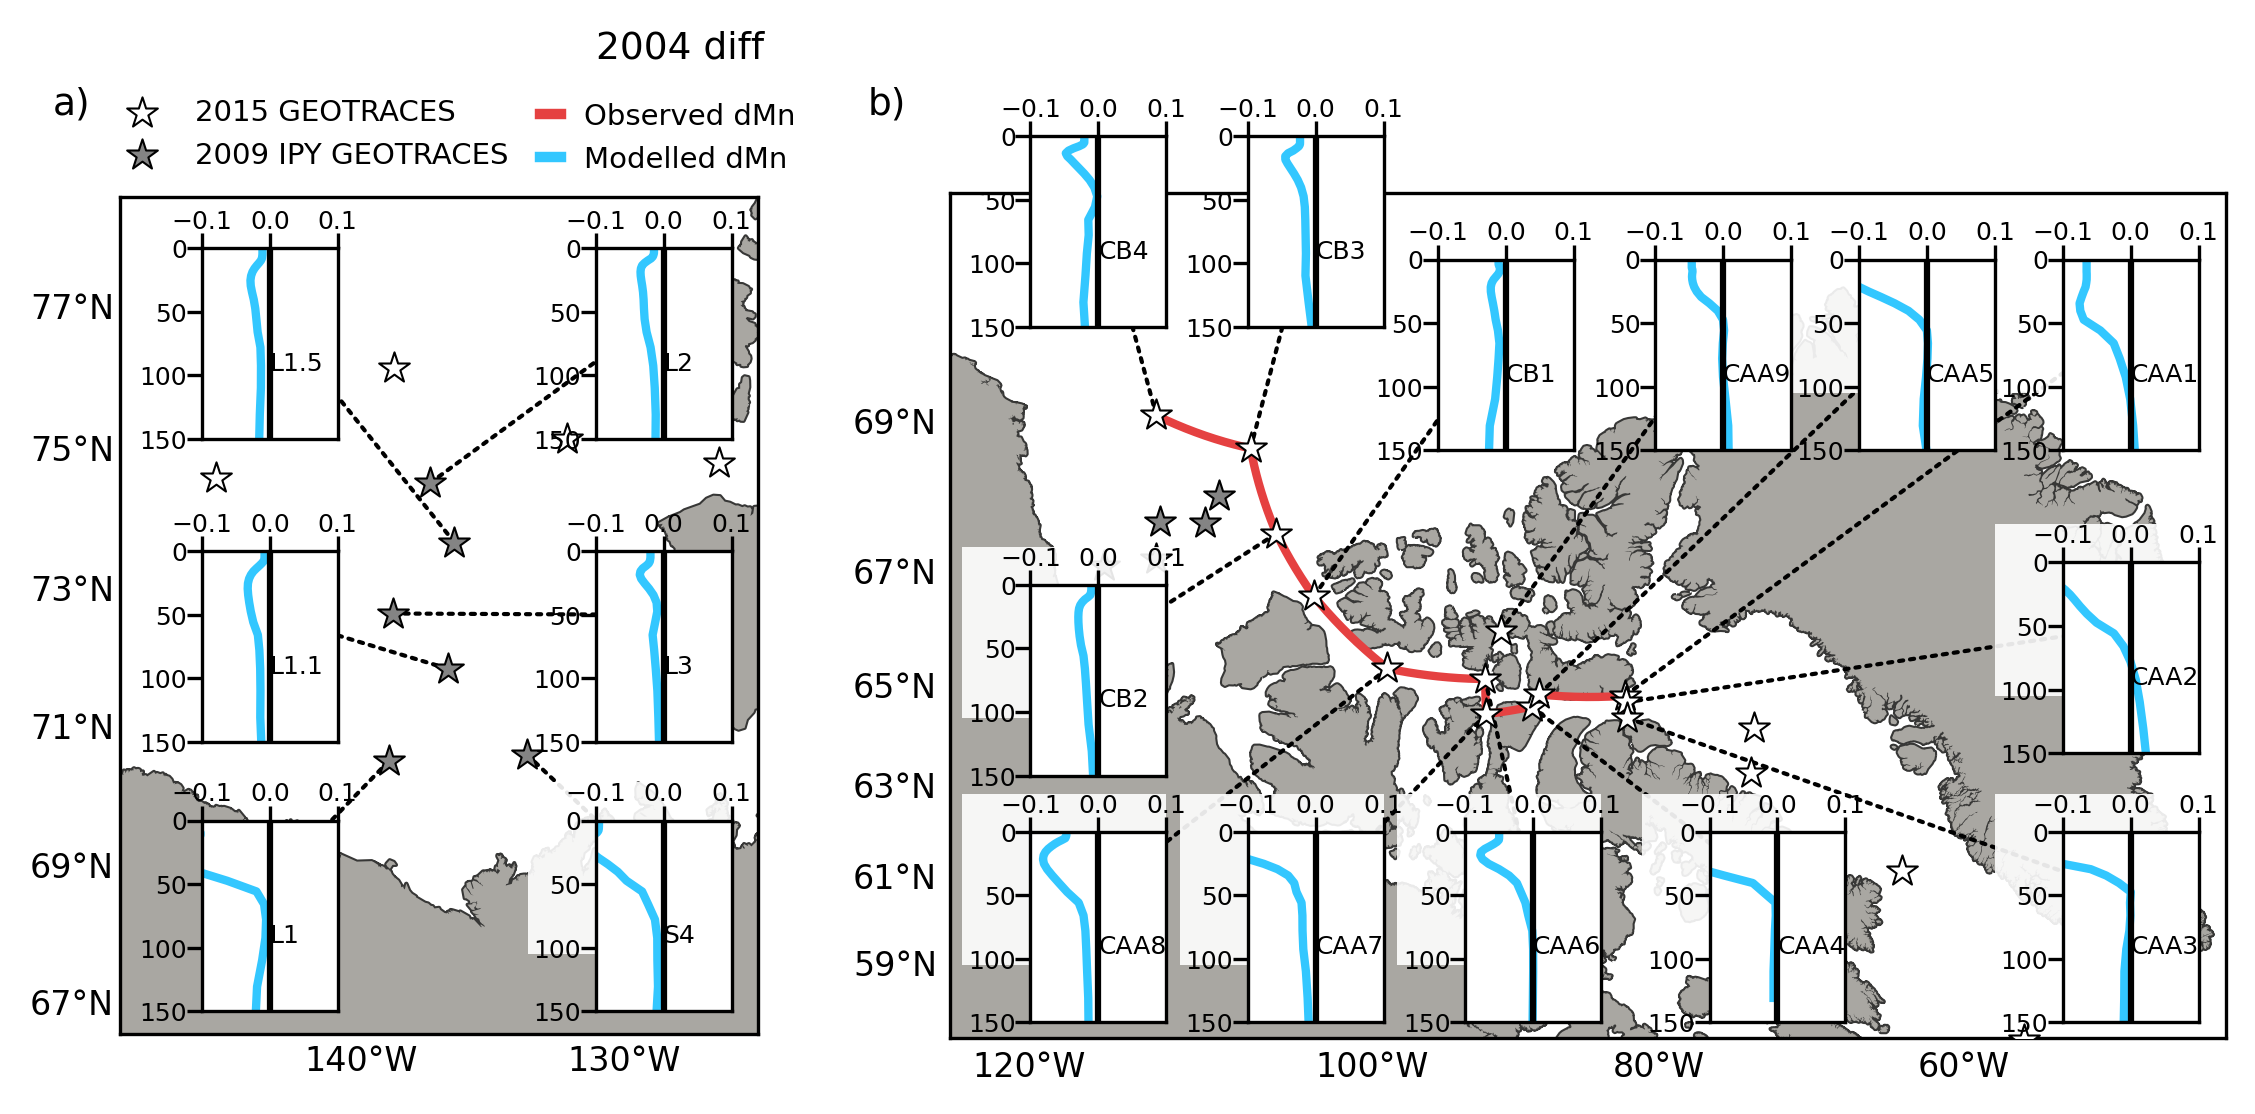

In [25]:
full_figure(ln_full=False, title='2004 diff')

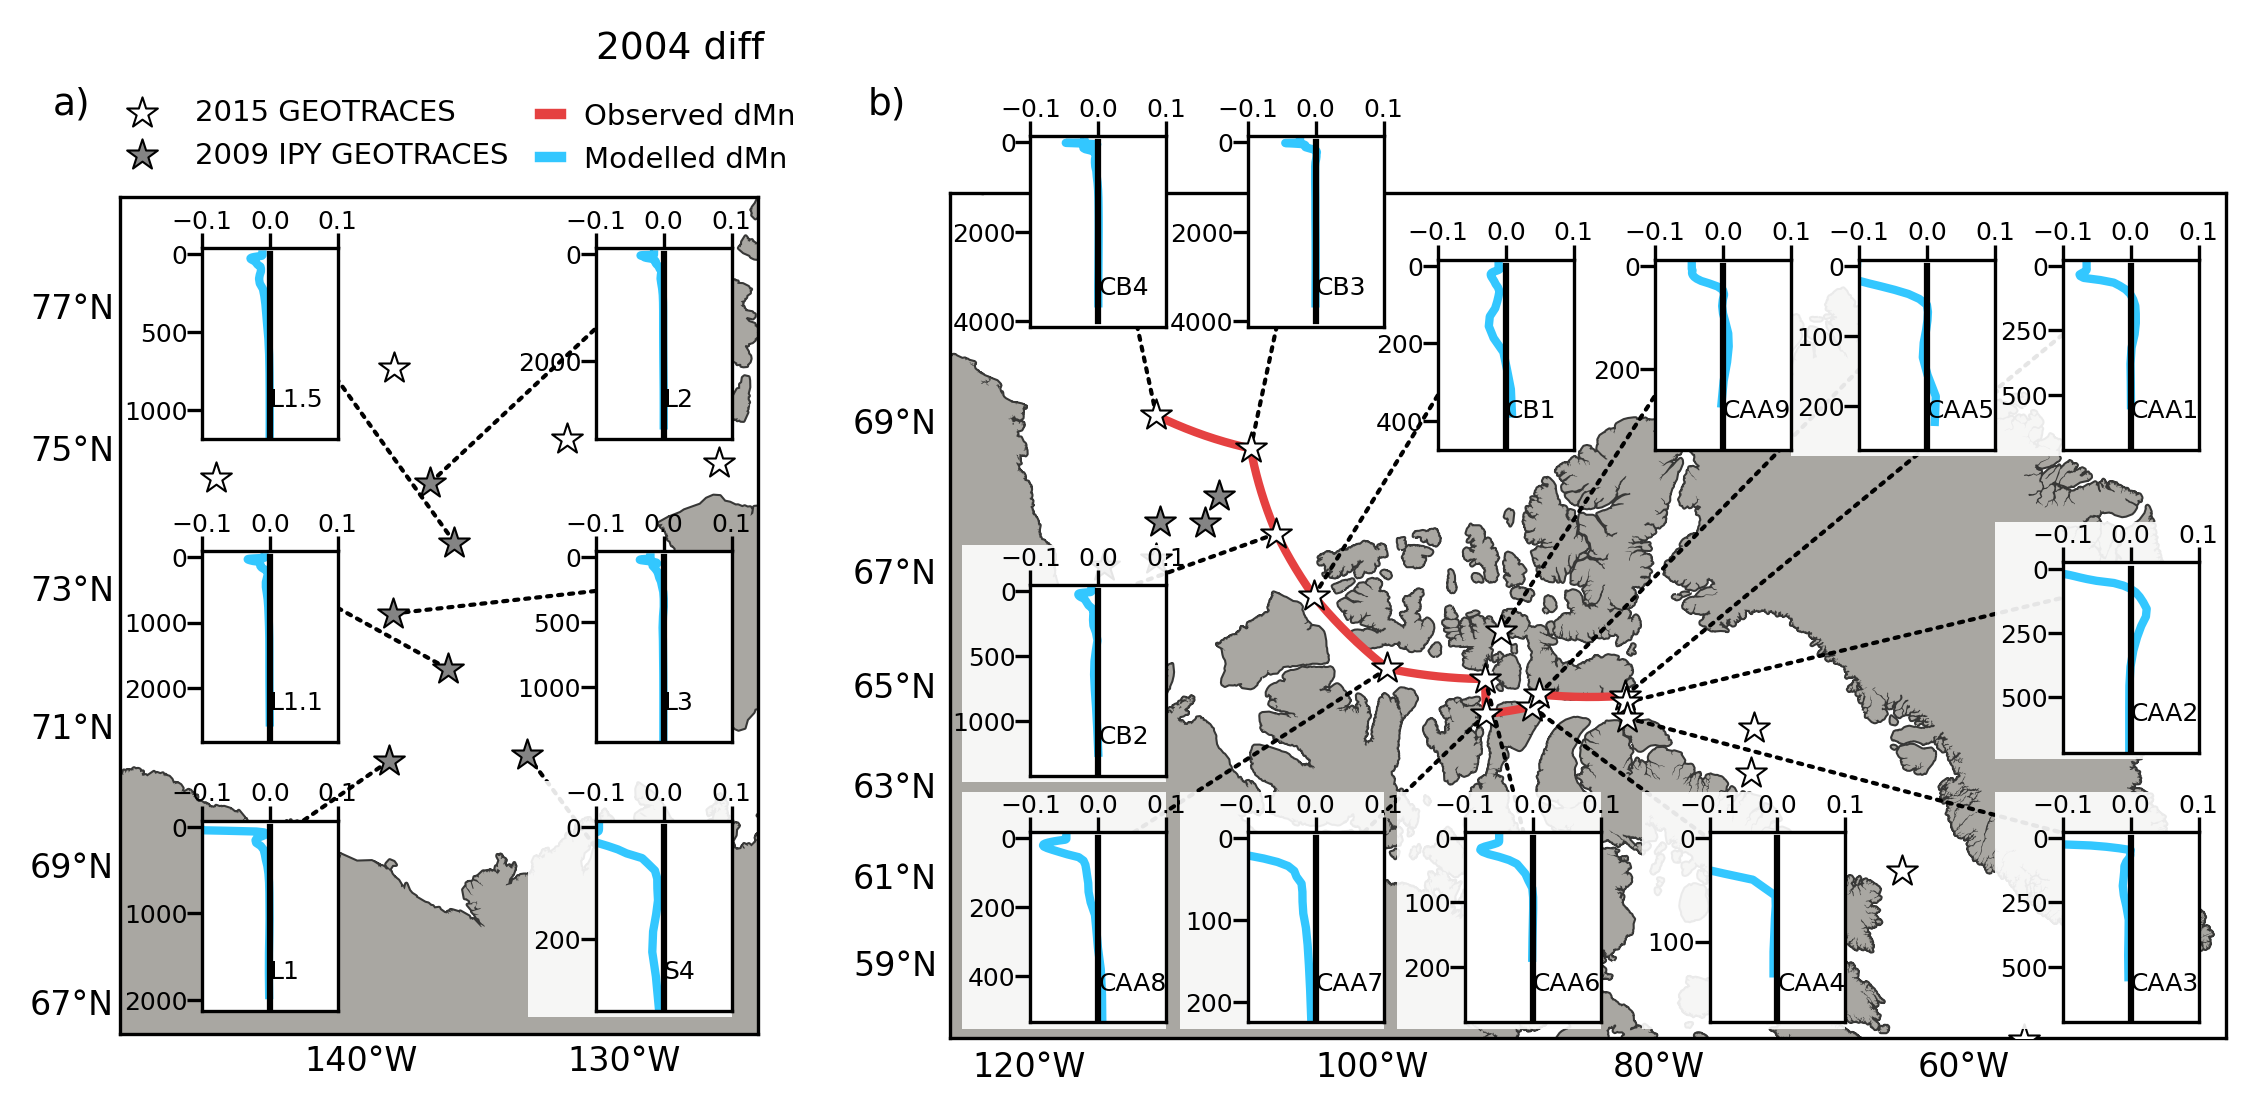

In [26]:
full_figure(ln_full=True, title='2004 diff')

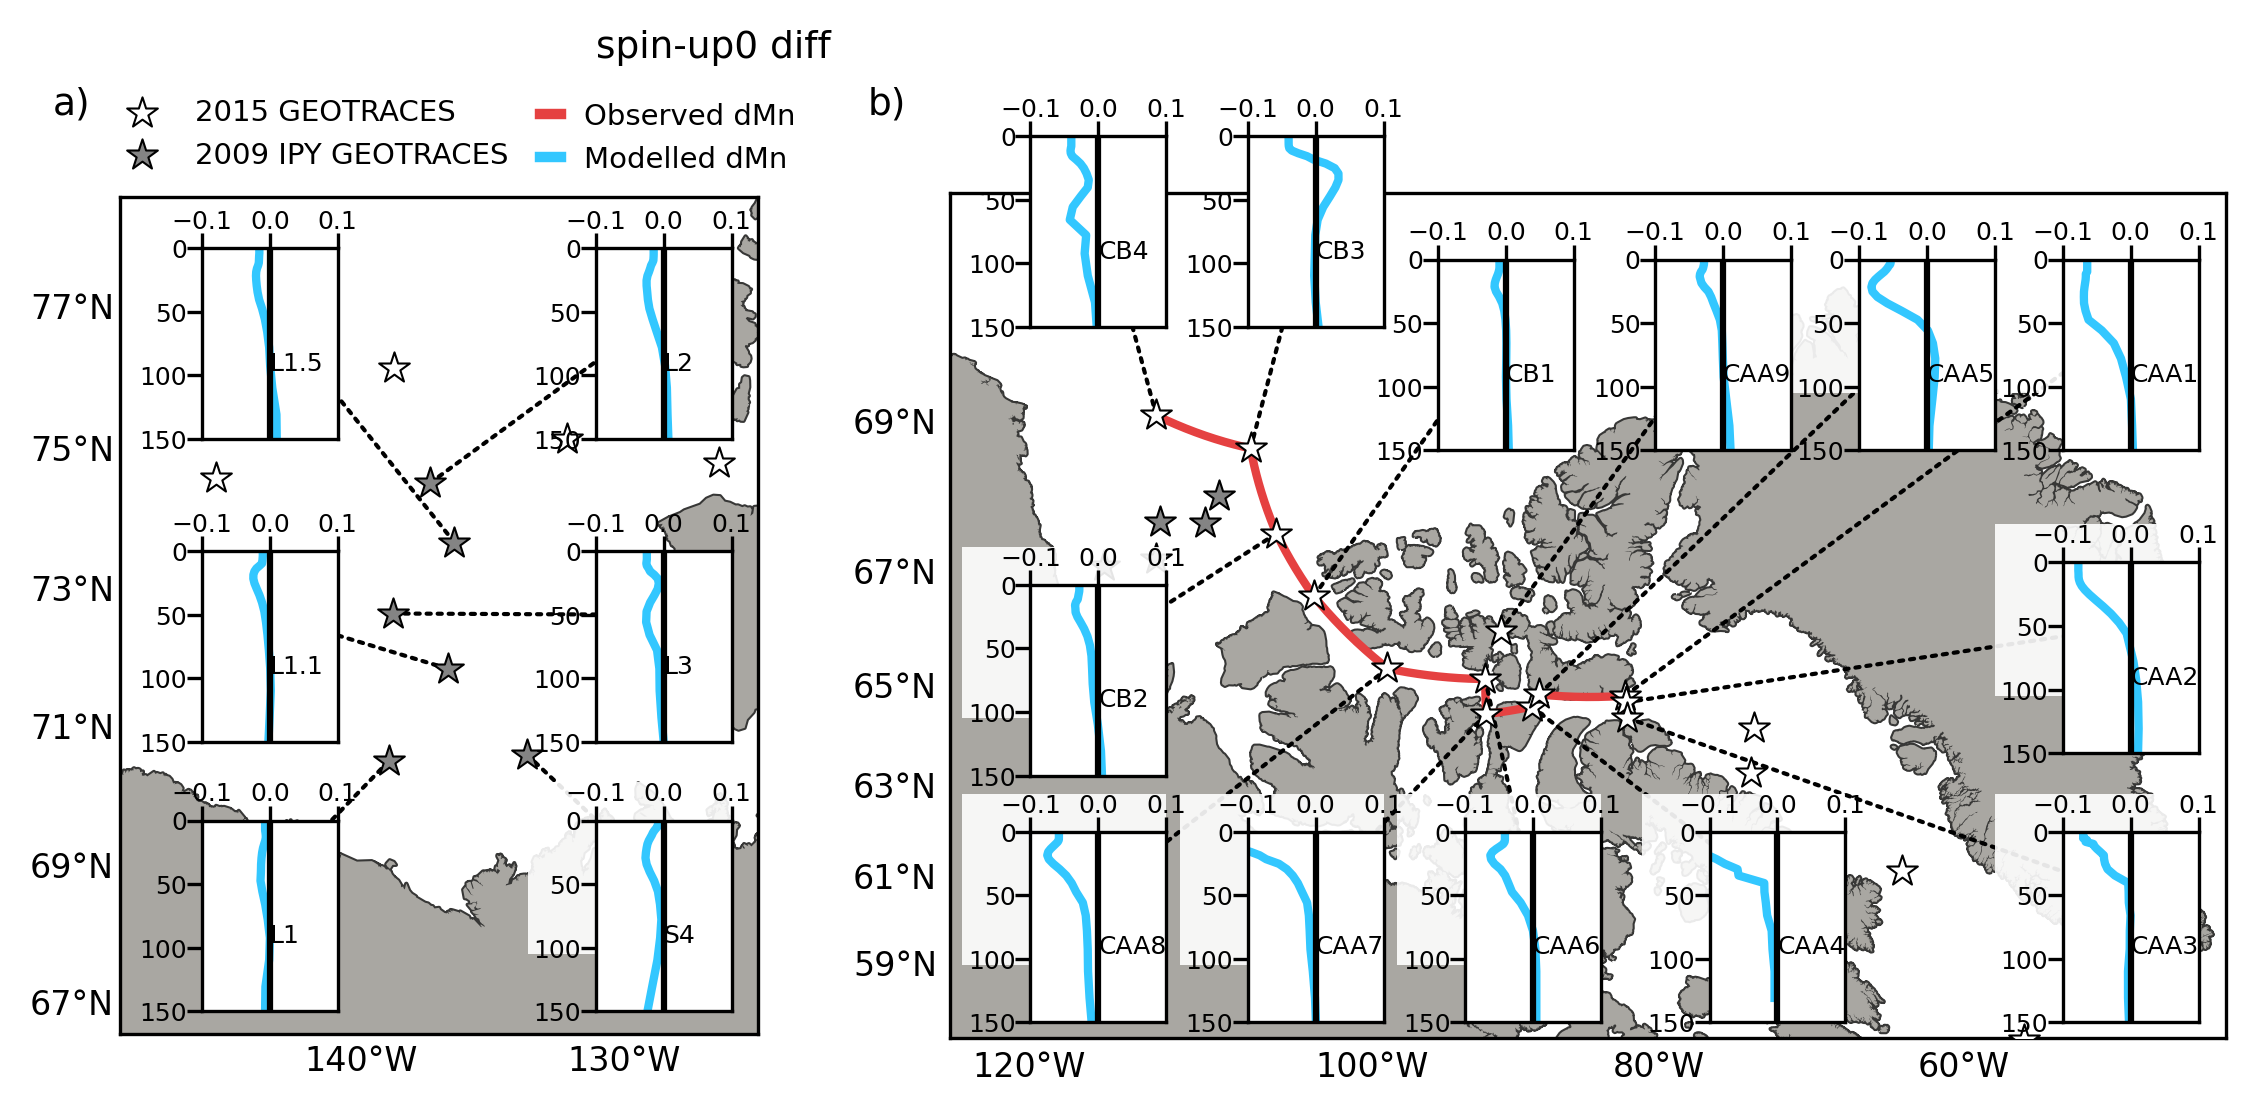

In [55]:
full_figure(ln_full=False, title='spin-up0 diff')

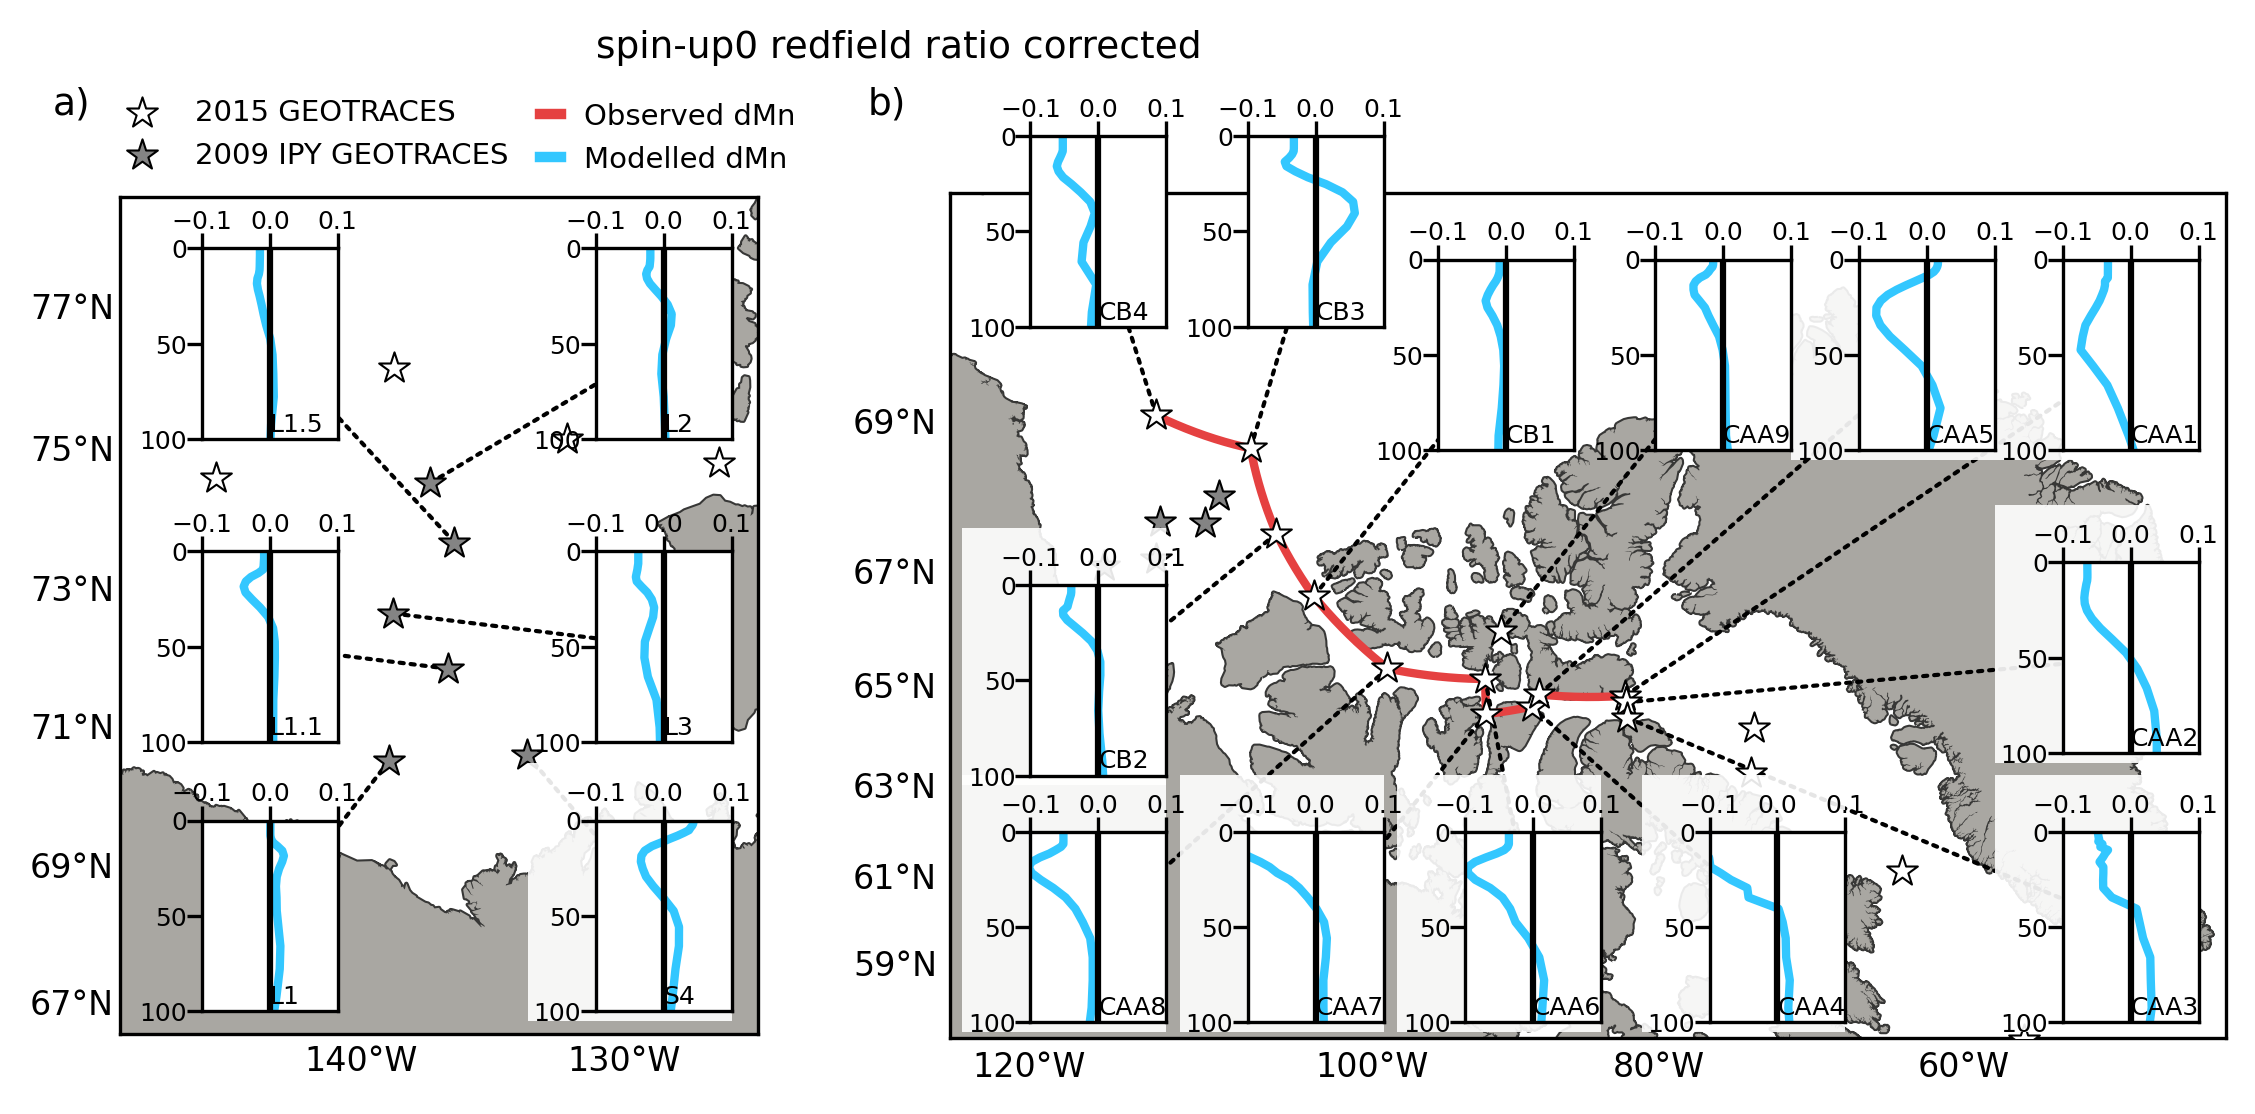

In [40]:
full_figure(ln_full=False, title='spin-up0 redfield ratio corrected')

https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.2015.0290